##Data Loading and splitting

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

In [ ]:
import splitfolders

In [ ]:
input_folder='/content/drive/MyDrive/CV_A2/dataset/UCMerced_LandUse/Images'
splitfolders.ratio(input_folder,output='/content/drive/MyDrive/CV_A2/data', ratio=(0.7,0.2,0.1))

Copying files: 2100 files [06:07,  5.72 files/s]


##Preprocessing and Training

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [5]:
train_dir = '/content/drive/MyDrive/CV_A2/data/train'
validation_dir = '/content/drive/MyDrive/CV_A2/data/val'
test_dir = '/content/drive/MyDrive/CV_A2/data/test'

# Parameters
batch_size = 64
img_height = 224
img_width = 224
num_classes = 21

In [9]:
# Load pre-trained VGG16 model (without the top FC layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom output layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # num_classes = number of output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

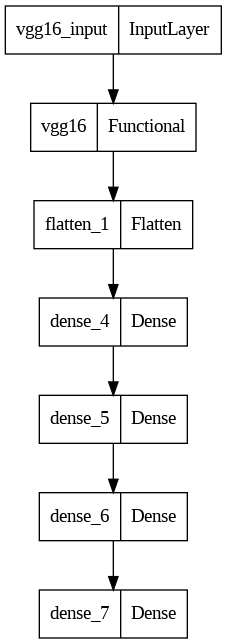

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_dataset = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1470 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


In [12]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset
)

Epoch 1/20
23/23 [==============================] - 392s 17s/step - loss: 2.7357 - accuracy: 0.1946 - val_loss: 1.9801 - val_accuracy: 0.3857
Epoch 2/20
23/23 [==============================] - 28s 1s/step - loss: 1.5718 - accuracy: 0.5122 - val_loss: 1.1133 - val_accuracy: 0.6690
Epoch 3/20
23/23 [==============================] - 30s 1s/step - loss: 0.9629 - accuracy: 0.6810 - val_loss: 0.8016 - val_accuracy: 0.7333
Epoch 4/20
23/23 [==============================] - 28s 1s/step - loss: 0.7786 - accuracy: 0.7374 - val_loss: 0.6523 - val_accuracy: 0.7976
Epoch 5/20
23/23 [==============================] - 28s 1s/step - loss: 0.5948 - accuracy: 0.8170 - val_loss: 0.5685 - val_accuracy: 0.8119
Epoch 6/20
23/23 [==============================] - 29s 1s/step - loss: 0.5228 - accuracy: 0.8238 - val_loss: 0.5882 - val_accuracy: 0.7929
Epoch 7/20
23/23 [==============================] - 31s 1s/step - loss: 0.4849 - accuracy: 0.8463 - val_loss: 0.4451 - val_accuracy: 0.8524
Epoch 8/20
23/23 [

In [14]:
model.save("/content/drive/My Drive/CV_A2/terrain20epoch.h5")

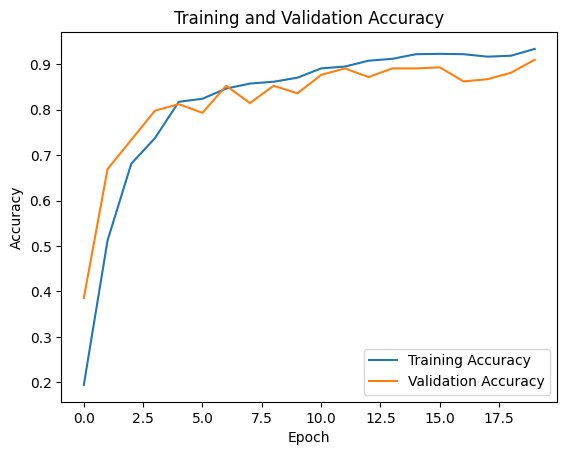

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


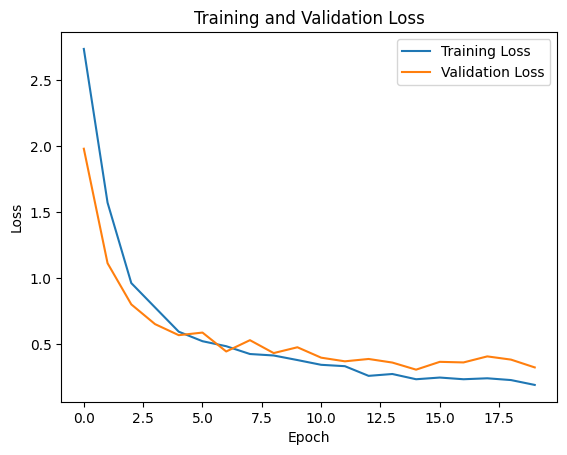

In [16]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Model evaluation

In [17]:
# Evaluate the model
test_dataset = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 210 images belonging to 21 classes.


In [18]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', "{:.2f}".format(test_acc*100), '%')
print('Test loss', test_loss)

4/4 [==============================] - 37s 12s/step - loss: 0.4692 - accuracy: 0.8667
Test accuracy: 86.67 %
Test loss 0.46920427680015564


In [37]:
import numpy as np

# Classification Visualization
class_names = sorted(train_dataset.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

# Get a batch of test data
images, labels = next(test_dataset)

# Make predictions
predictions = model.predict(images)


2/2 [==============================] - 0s 161ms/step


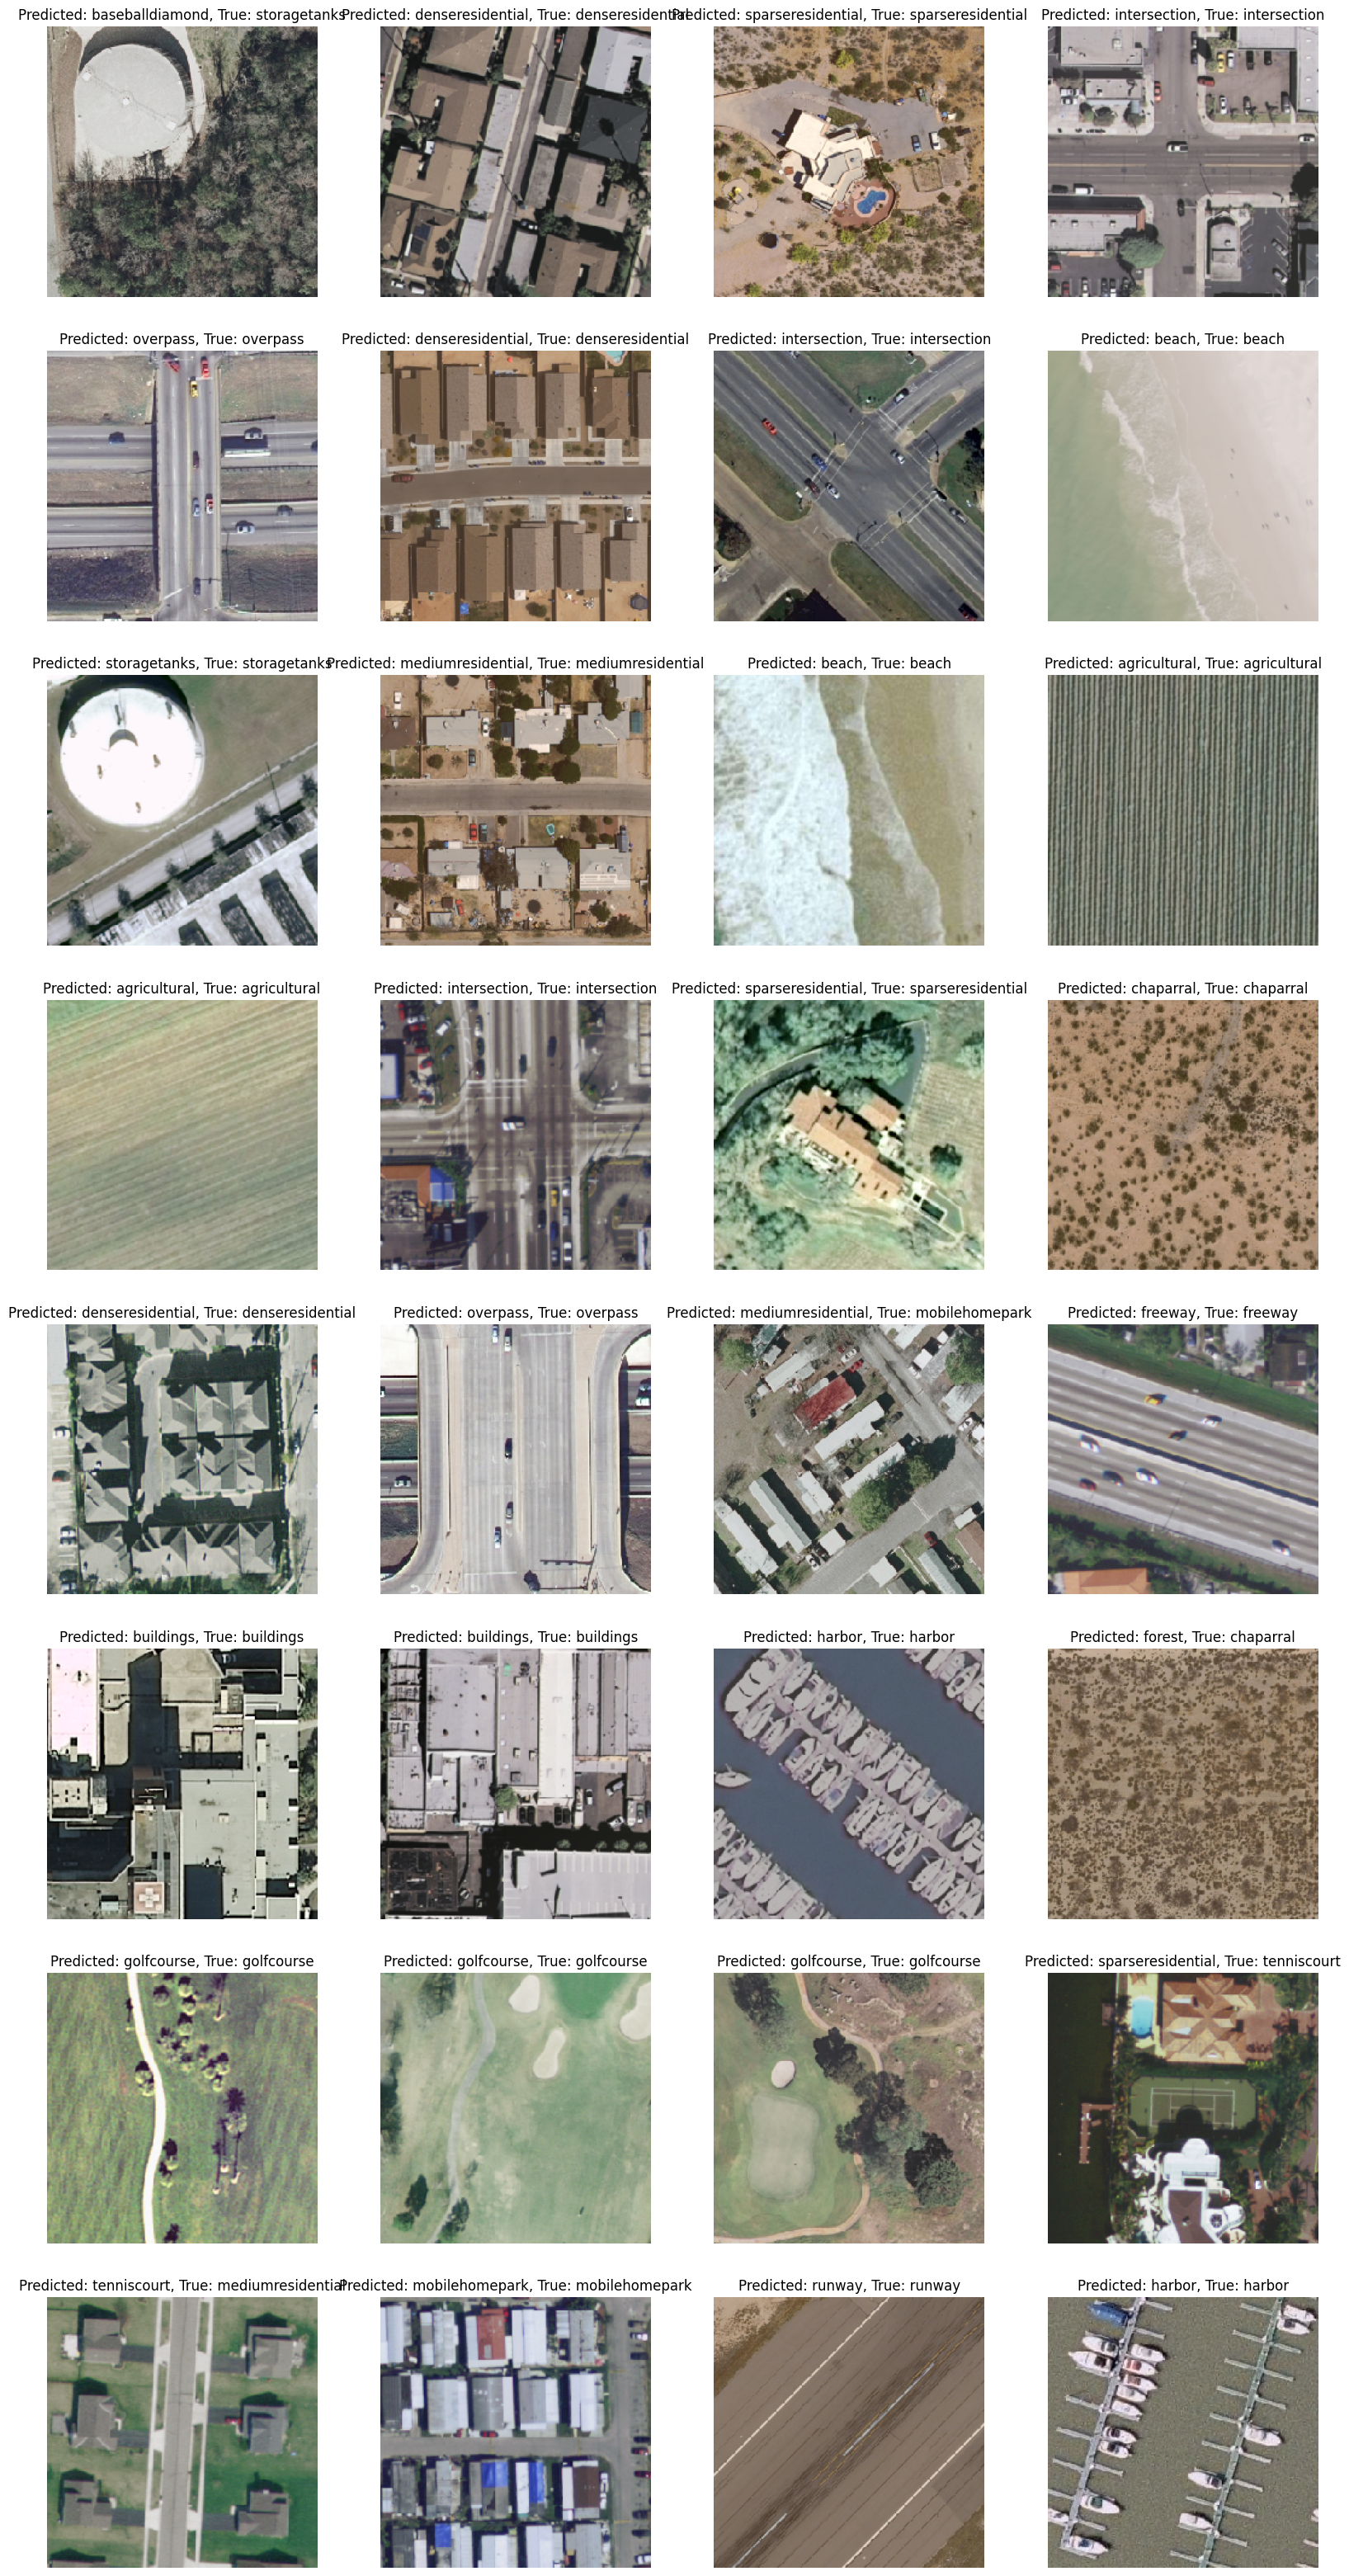

In [41]:
# Visualize the results
plt.figure(figsize=(20, 40))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(images[i])
    plt.title("Predicted: {}, True: {}".format(class_names[np.argmax(predictions[i])],
                                                class_names[np.argmax(labels[i])]))
    plt.axis("off")

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
predicted_labels = np.argmax(predictions, axis=1)
true_labels = labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

4/4 [==============================] - 2s 361ms/step


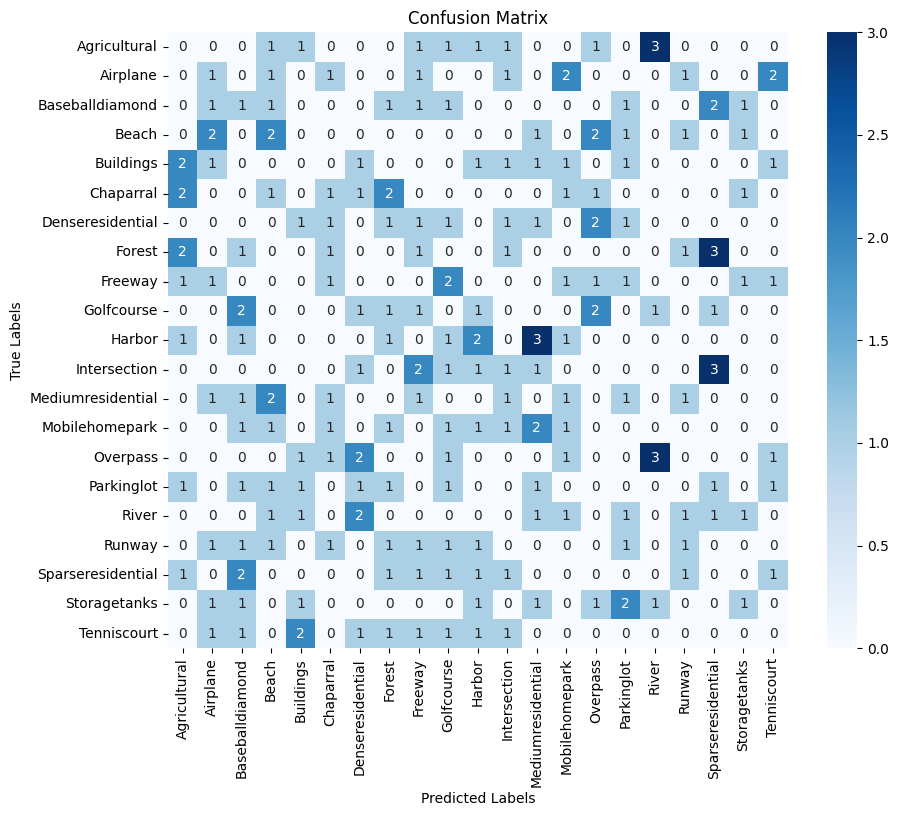

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_dataset.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

4/4 [==============================] - 2s 431ms/step


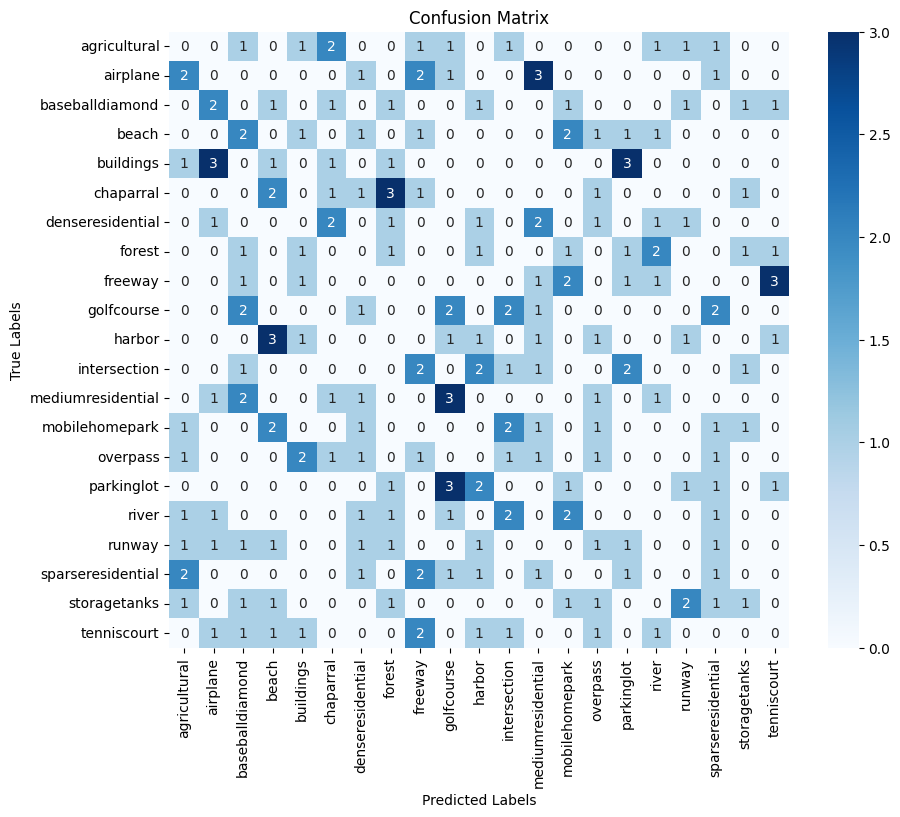

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
pred = model.predict(test_dataset)
predicted_labels = np.argmax(pred, axis=1)
true_labels = test_dataset.classes

# Get class names
class_names = list(test_dataset.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [62]:
print(test_dataset.classes)

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20]


In [66]:
print(predictions[0])

[1.2477208e-08 3.2137740e-07 1.0650436e-05 8.9901205e-06 5.2318121e-08
 2.0314990e-06 4.9340920e-10 9.9724716e-01 1.7427711e-06 8.4070300e-05
 4.1201946e-12 6.0740657e-09 1.3769596e-06 1.8777276e-06 5.1669033e-09
 3.5070435e-08 1.0367164e-03 1.4190974e-11 1.6032158e-03 1.4678754e-06
 8.0637960e-08]


4/4 [==============================] - 3s 470ms/step


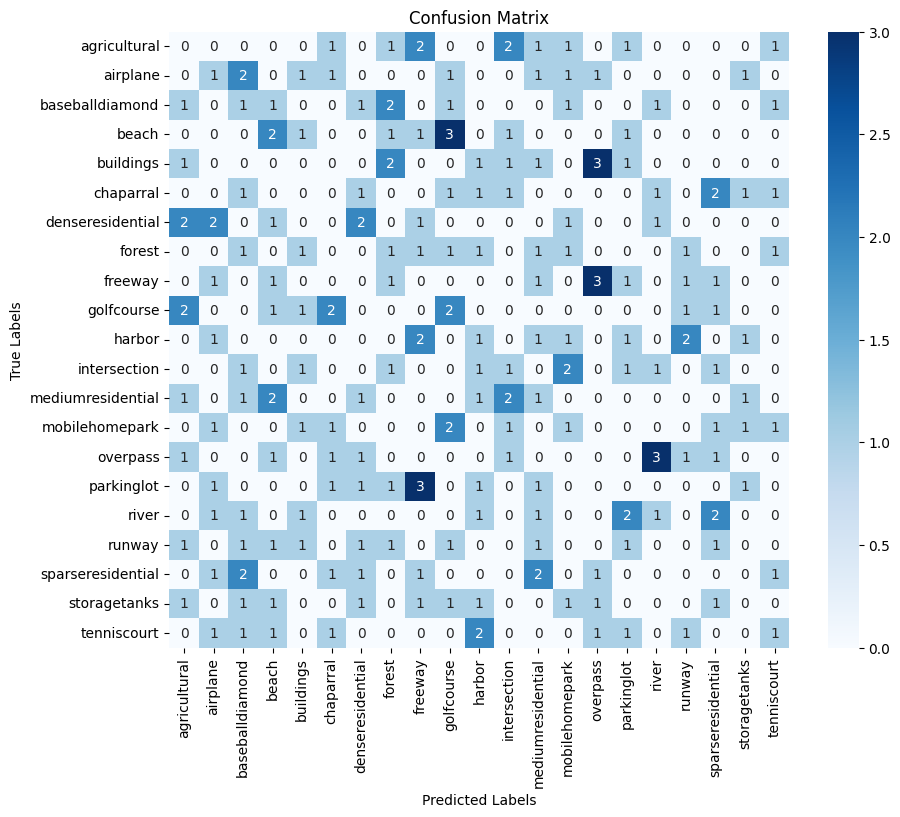

In [67]:
import os

# Get true labels from the filenames
true_labels = []
for filename in test_dataset.filenames:
    class_name = os.path.dirname(filename)
    label = test_dataset.class_indices[class_name]
    true_labels.append(label)

# Get class names
class_names = list(test_dataset.class_indices.keys())

# Make predictions on the test set
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [69]:
print(true_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


2/2 [==============================] - 0s 151ms/step


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

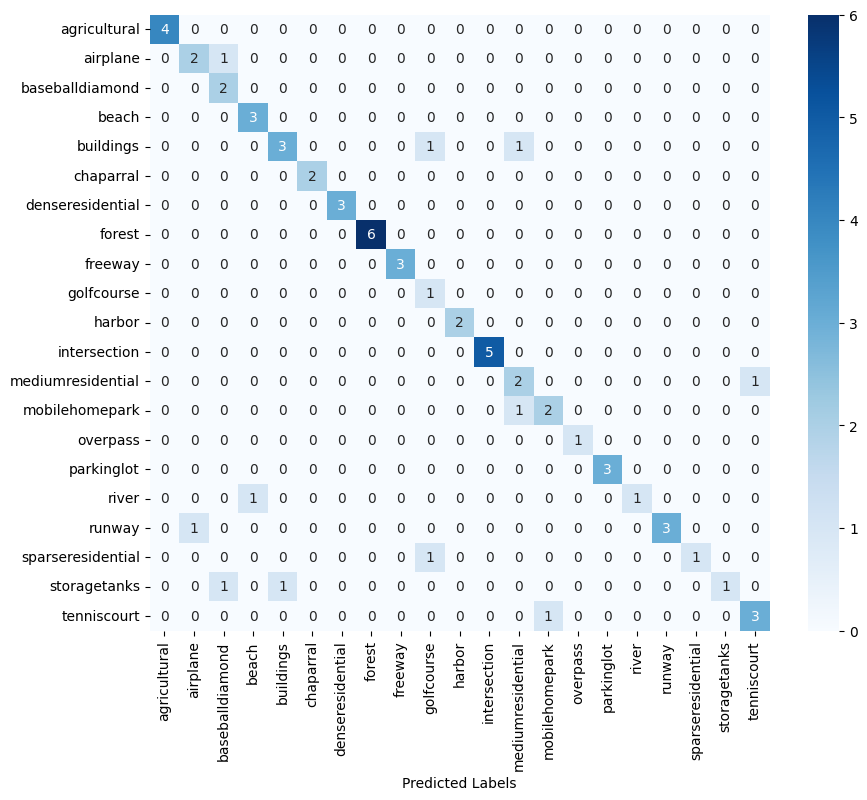

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get one batch of test data
images, true_labels = next(test_dataset)
true_labels=np.argmax(true_labels,axis=1)
# Make predictions on the batch
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Get class names
class_names = list(test_dataset.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt
